In [2]:
import json, os, sys,warnings,datetime
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt                  # plots

from scipy.optimize import minimize              # for function minimization

pd.options.display.max_rows = 9999999
pd.options.display.max_columns = 99999999

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, leaves_list,to_tree, fcluster
import dask.dataframe as dd

In [3]:
# Get KPI data of for different domain from parquet files. All KPI's are stored in a Data Frame.
file_list = ["GGSN_20210510_063000.parquet",
             "MME_20210510_063000.parquet",
             "tas_20210510_063000.parquet",
             "uag_20210510_063000.parquet"]
color_list = ["Red","Green","Blue","Black","c","m","Yellow"]
i=0
color_column_dict = {}
color_domain_dict = {}

for file in file_list:
    
    color_domain_dict[file.split("_")[0]] = color_list[i]
    
    file_name = "cross_domain/cross/{}".format(file)
    df = dd.read_parquet(file_name, engine="pyarrow")
    df = df.compute()
    df = df.reset_index()
    for col in df.columns:
        if col != "DATETIME":
            color_column_dict[col] = color_list[i]
    i=i+1
    if file == file_list[0]:
        df_all = df
    else:
        df_all = df_all.merge(df,on="DATETIME",how="outer")

df_all = df_all.sort_values(by="DATETIME")
df_all = df_all.set_index("DATETIME")
df_all = df_all.resample('30min').mean()
df_all = df_all.fillna(method="ffill")
df_all = df_all.fillna(method="bfill")
df_all = df_all.dropna(axis=1)
df_kpi = df_all 
for col in df_kpi.columns:
    if df_kpi[[col]].mean()[0] == 0.0:
        df_kpi = df_kpi.drop(col,axis=1)

In [4]:
df_kpi.head()

,SOHGGSN04-s5_s8_sgw_incsuc_create_defa,MBESGSN05-srvcctowcdmafailureratio,GBESGSN01-pdpcntxtfailurepc_2g,immavtassc24-sas_atusti_sr,gbmavtassc32-sas_atusti_conf_sr,immavtassc24-immavtassc24-sas_atusti_sr,immavtassc11-tas_ss_add_conf_partcpnt_sr,immavtassc11-immavtassc11-tas_ss_add_conf_partcpnt_sr,anmavuag1sc1-uag_cc_unexpect_sign_in_state,anmavuag1sc11-uag_cc_unexpect_sign_in_state,anmavuag2sc2-uag_cc_unexpect_sign_in_state,anmavuag2sc3-uag_cc_unexpect_sign_in_state,anmavuag3sc17-uag_cc_unexpect_sign_in_state,gbmavuag2sc1-uag_cc_unexpect_sign_in_state,gbmavuag2sc19-uag_cc_unexpect_sign_in_state,gbmavuag2sc21-uag_cc_unexpect_sign_in_state,gbmavuag2sc3-uag_cc_unexpect_sign_in_state,gbmavuag3sc1-uag_cc_unexpect_sign_in_state,immavuag1sc15-uag_cc_unexpect_sign_in_state,immavuag1sc19-uag_cc_unexpect_sign_in_state,immavuag1sc21-uag_cc_unexpect_sign_in_state,immavuag1sc6-uag_cc_unexpect_sign_in_state,immavuag2sc8-uag_cc_unexpect_sign_in_state,immavuag3sc2-uag_cc_unexpect_sign_in_state,immavuag3sc22-uag_cc_unexpect_sign_in_state
DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-01 00:30:00,65.0,0.073364,0.523438,100.0,100.0,100.0,100.0,100.0,21.065625,16.731250,159.726562,16.267187,41.606771,14.600000,108.137500,17.600000,17.998438,21.800000,16.734375,18.131250,20.401563,26.468750,16.067187,22.268750,20.734375
2021-05-01 01:00:00,65.0,0.073364,0.523438,100.0,100.0,100.0,100.0,100.0,29.165365,16.222656,17.057292,17.278646,41.606771,16.720052,100.104167,18.781250,15.222656,21.609375,122.166667,18.305990,18.386719,21.611979,19.277344,20.777344,19.332031
2021-05-01 01:30:00,65.0,0.073364,0.523438,100.0,100.0,100.0,100.0,100.0,103.781250,110.828125,15.889323,16.554688,41.606771,18.363281,106.552083,16.333333,18.389323,17.055990,12.945312,14.972656,14.942708,13.500000,13.388021,13.777344,19.221354
2021-05-01 02:00:00,65.0,0.073364,0.523438,100.0,100.0,100.0,100.0,100.0,27.385417,20.500000,18.445312,19.388021,41.606771,16.666667,104.000000,17.386719,17.502604,22.778646,17.718750,16.889323,17.110677,14.500000,18.389323,18.888021,16.722656
2021-05-01 02:30:00,65.0,0.073364,0.523438,100.0,100.0,100.0,100.0,100.0,14.998698,15.610677,18.223958,123.777344,41.606771,131.721354,98.677083,15.000000,16.278646,13.387370,15.721354,84.276042,20.441406,78.625000,14.553385,19.223958,15.333333


In [5]:
# Distance matrix is calculated from the correlation function of Pandas. Pearson method is used.
distance_matrix = df_kpi.corr(method='pearson')
distance_matrix = distance_matrix.abs()
distance_matrix.head()

,SOHGGSN04-s5_s8_sgw_incsuc_create_defa,MBESGSN05-srvcctowcdmafailureratio,GBESGSN01-pdpcntxtfailurepc_2g,immavtassc24-sas_atusti_sr,gbmavtassc32-sas_atusti_conf_sr,immavtassc24-immavtassc24-sas_atusti_sr,immavtassc11-tas_ss_add_conf_partcpnt_sr,immavtassc11-immavtassc11-tas_ss_add_conf_partcpnt_sr,anmavuag1sc1-uag_cc_unexpect_sign_in_state,anmavuag1sc11-uag_cc_unexpect_sign_in_state,anmavuag2sc2-uag_cc_unexpect_sign_in_state,anmavuag2sc3-uag_cc_unexpect_sign_in_state,anmavuag3sc17-uag_cc_unexpect_sign_in_state,gbmavuag2sc1-uag_cc_unexpect_sign_in_state,gbmavuag2sc19-uag_cc_unexpect_sign_in_state,gbmavuag2sc21-uag_cc_unexpect_sign_in_state,gbmavuag2sc3-uag_cc_unexpect_sign_in_state,gbmavuag3sc1-uag_cc_unexpect_sign_in_state,immavuag1sc15-uag_cc_unexpect_sign_in_state,immavuag1sc19-uag_cc_unexpect_sign_in_state,immavuag1sc21-uag_cc_unexpect_sign_in_state,immavuag1sc6-uag_cc_unexpect_sign_in_state,immavuag2sc8-uag_cc_unexpect_sign_in_state,immavuag3sc2-uag_cc_unexpect_sign_in_state,immavuag3sc22-uag_cc_unexpect_sign_in_state
SOHGGSN04-s5_s8_sgw_incsuc_create_defa,1.000000,0.254263,0.162613,0.260636,0.339941,0.204696,0.242098,0.154468,0.087263,0.317536,0.079335,0.226982,0.335515,0.130278,0.355300,0.209398,0.118340,0.501633,0.261087,0.276107,0.246848,0.198690,0.060999,0.120055,0.300171
MBESGSN05-srvcctowcdmafailureratio,0.254263,1.000000,0.415112,0.411005,0.858274,0.393821,0.566550,0.343465,0.122433,0.179788,0.118455,0.331908,0.425982,0.150451,0.264457,0.314282,0.221267,0.325373,0.296787,0.145707,0.248562,0.106766,0.041668,0.002998,0.237927
GBESGSN01-pdpcntxtfailurepc_2g,0.162613,0.415112,1.000000,0.216696,0.488702,0.219226,0.320155,0.221982,0.168401,0.240082,0.124164,0.357225,0.512235,0.152655,0.261662,0.377521,0.157817,0.255975,0.308425,0.124769,0.252098,0.188644,0.147461,0.106024,0.274833
immavtassc24-sas_atusti_sr,0.260636,0.411005,0.216696,1.000000,0.453944,0.951089,0.572952,0.456888,0.072898,0.146779,0.159182,0.154496,0.210955,0.159292,0.156304,0.189054,0.096687,0.227399,0.284825,0.121026,0.160172,0.099403,0.151205,0.105179,0.114250
gbmavtassc32-sas_atusti_conf_sr,0.339941,0.858274,0.488702,0.453944,1.000000,0.430458,0.620720,0.383120,0.110127,0.255570,0.167311,0.400416,0.512156,0.156848,0.346199,0.406374,0.258717,0.425110,0.365960,0.163311,0.332188,0.165319,0.108231,0.028951,0.320343


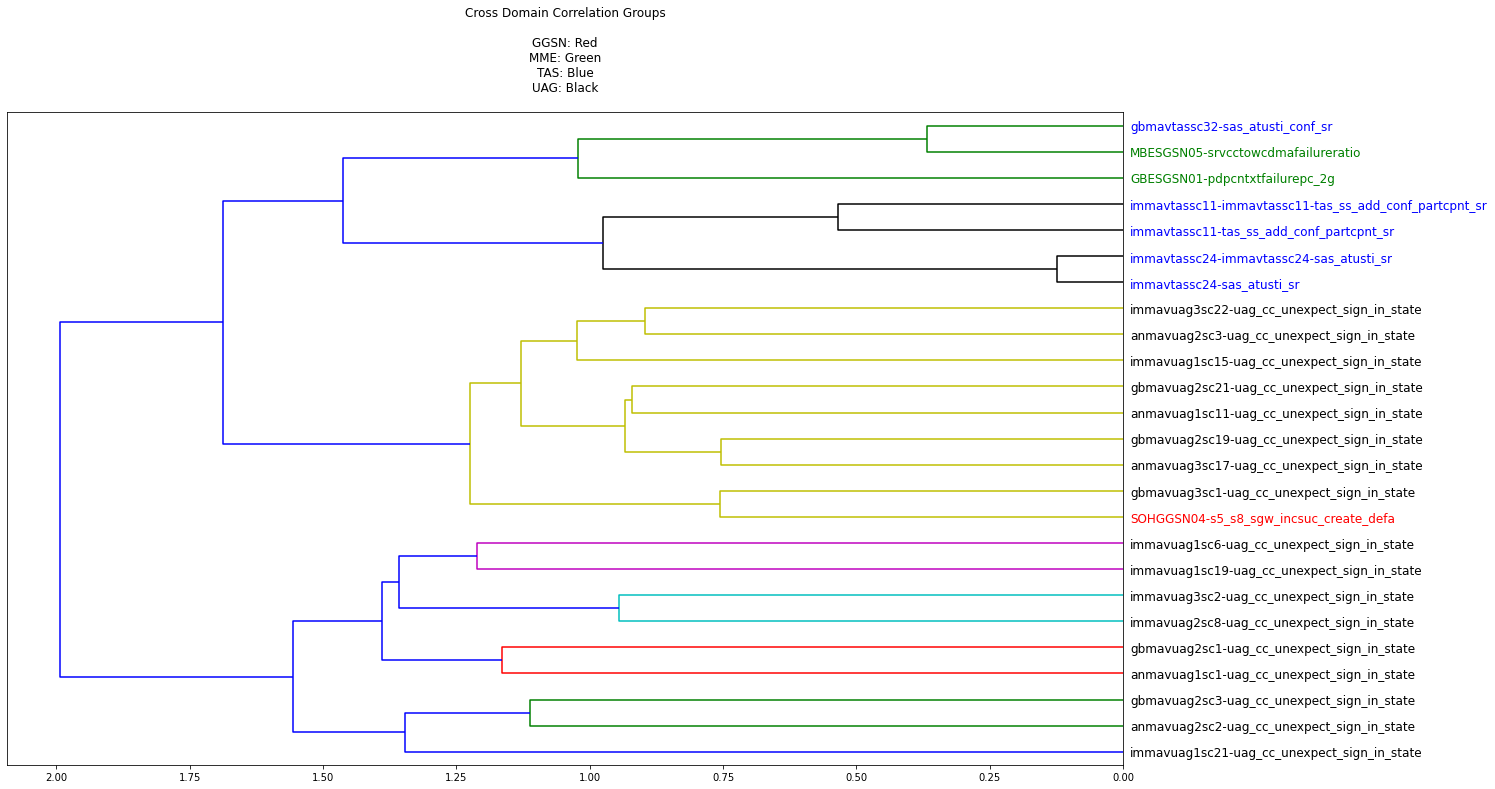

In [6]:
# Below code is to calculate Dendogram which shows different KPI groups. Threshold is given for the minimum distance to
# form a group. 

# In the Dendogram each color of KPI names represent an individual domain. And each color of horizontal lines are represent
# an individual correlation group.

threshold = 1.25

def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(20, 12))
    plt.clf()
    dn = dendrogram(Z,labels = distance_matrix.columns,orientation="left",color_threshold=threshold,leaf_font_size=12)
    
    label_colors = {}
    for col in distance_matrix.columns:
        label_colors[col] = color_column_dict[col]
        
    ay = plt.gca()
    xlbls = ay.get_ymajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    
    title = ""
    for domain in color_domain_dict:
        title = title + domain.upper()+": "+color_domain_dict[domain]+"\n"
 
    plt.title("Cross Domain Correlation Groups\n\n"+title)
    
    plt.show()
    
    return Z


linkage_matrix = hierarchical_clustering(distance_matrix)

cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')


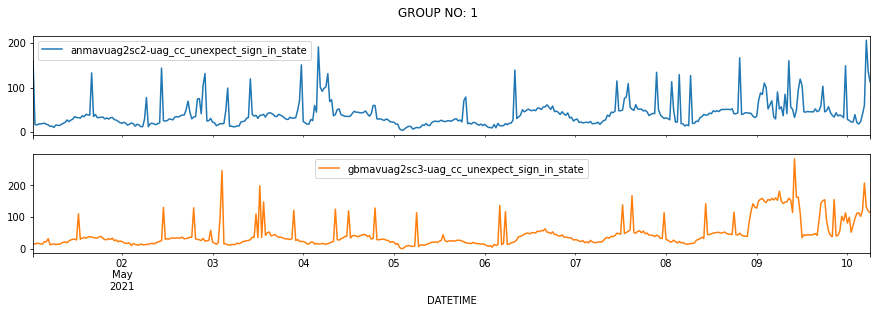

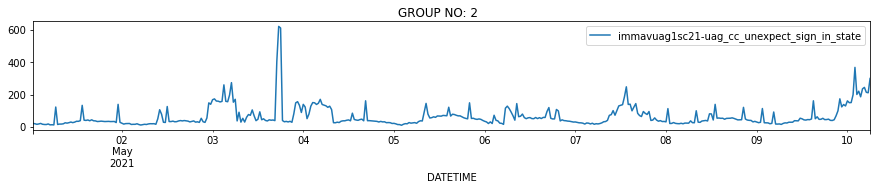

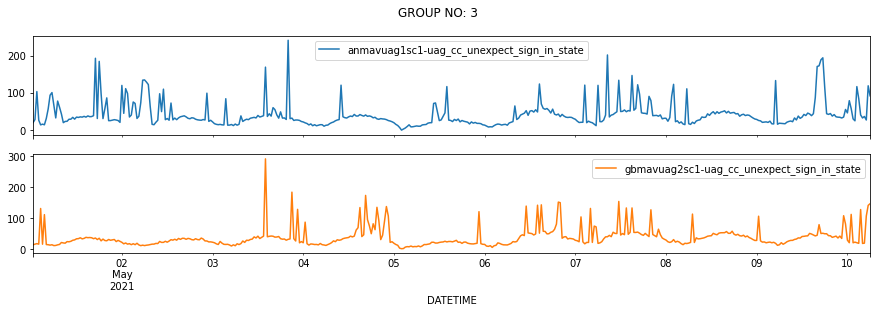

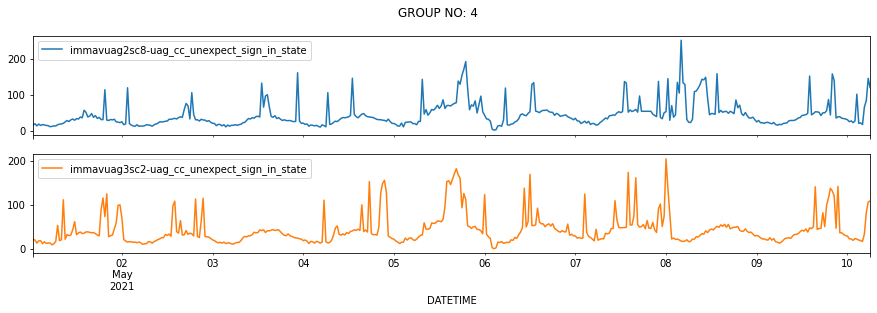

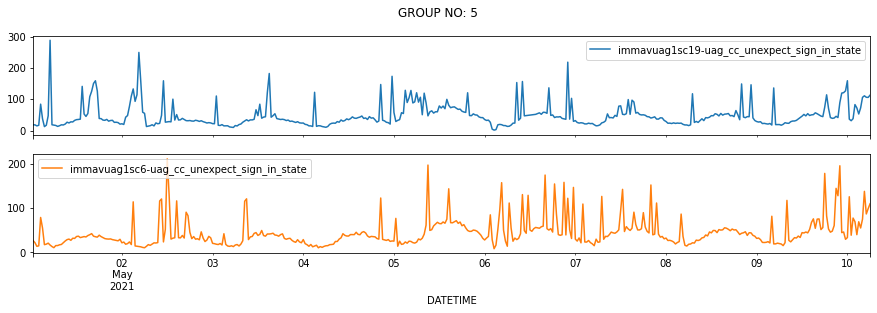

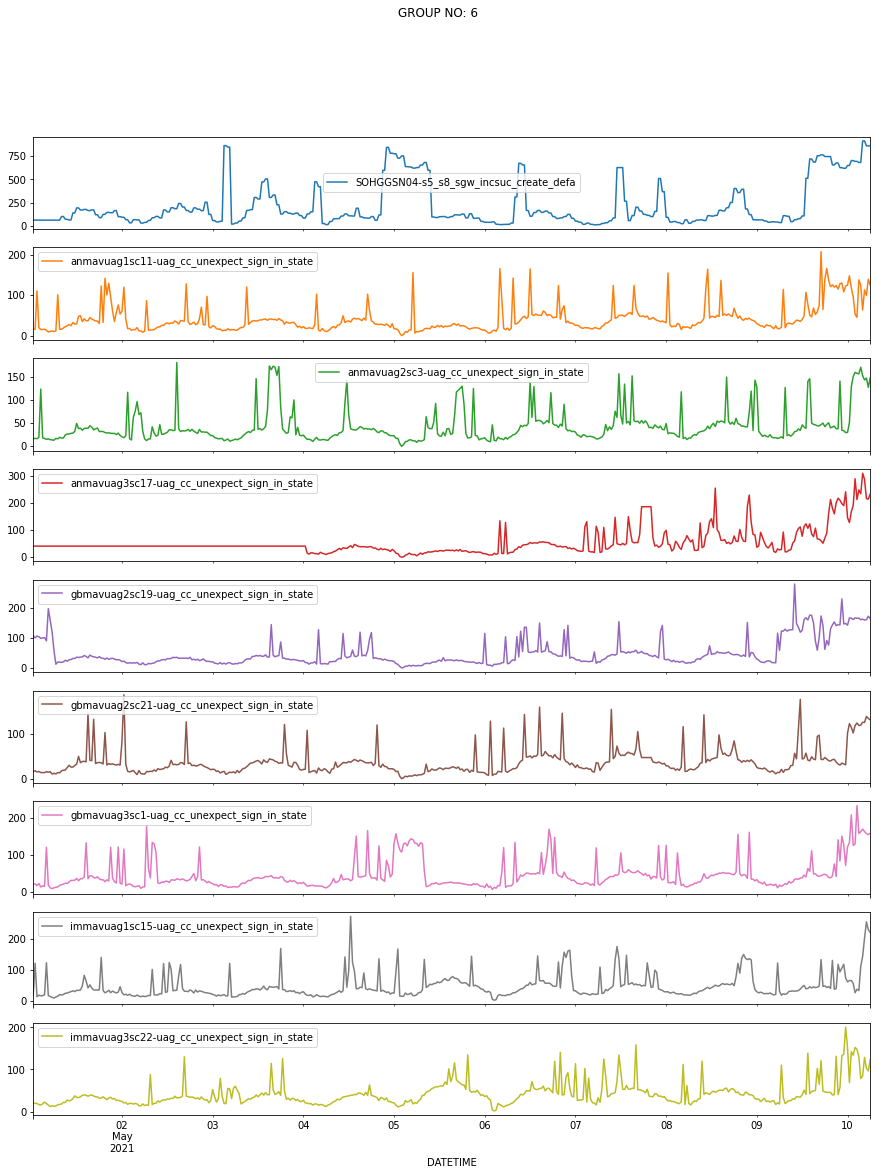

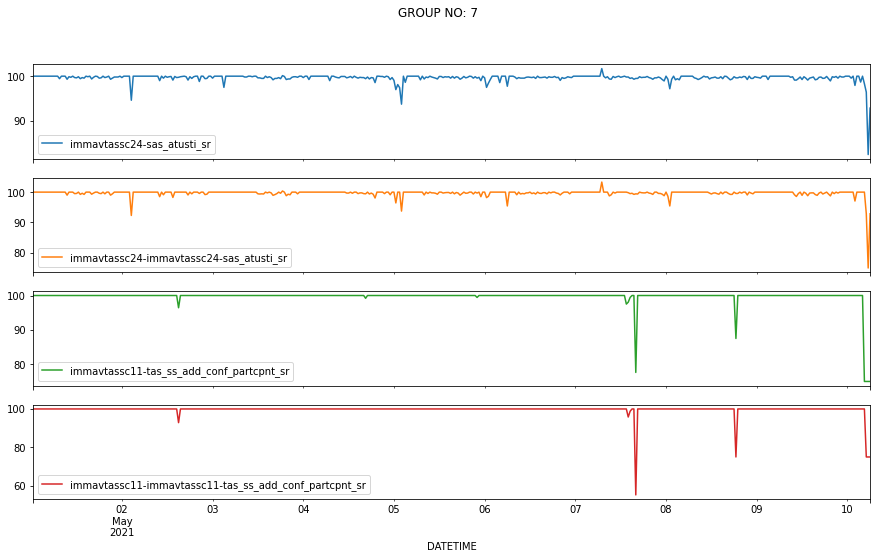

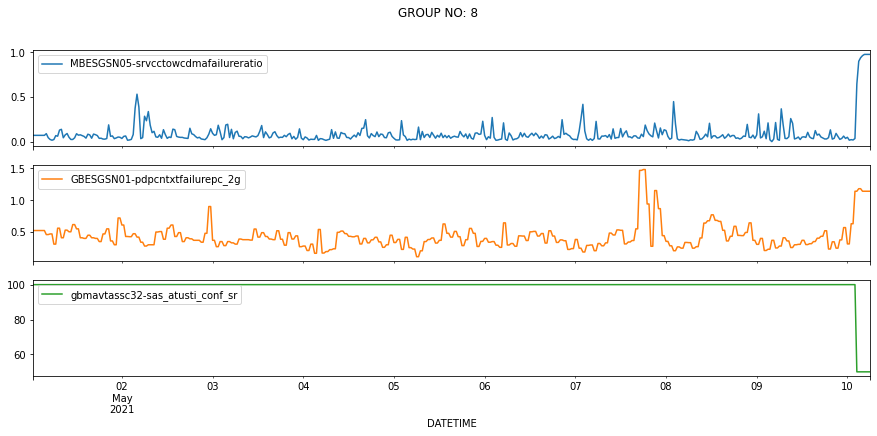

In [7]:
# Below are the KPI trends of each groups.
group_list = {}
for cluster in range(1,len(list(set(cluster_labels)))+1):
    group_list[cluster] = []
    i=0
    for index in range(len(cluster_labels)):
        if cluster == cluster_labels[index]:
            group_list[cluster].append(df_kpi.columns[index])
            i = i + 1

for grp in group_list:
    group_size = len(group_list[grp])
    df_kpi[group_list[grp]].plot(subplots=True,figsize=(15, group_size*2),title="GROUP NO: "+str(grp))
